# rock physics models and templates

This is an attempt to implement rock physics models and templates into an IPython/Jupyter notebook.

I will define here 5 functions to implement the most basic, useful and easy to code rock physics models (RPM):

* critical porosity (Nur et al., 1991, 1995);
* Hertz-Mindlin, at the basis of soft and stiff sand models;
* soft sand model (Dvorkin and Nur, 1996)
* stiff sand model 
* cemented sand model (or contact cement model; Dvorkin and Nur, 1996)

I followed the equations written on the Rock Physics handbook (Mavko, Mukerji and Dvorkin, 2009, 2nd edition), but I was also helped by reading the sections on rock physics models found on my worn-out copies of Quantitative Seismic Interpretation (Avseth, Mukerji and Mavko, 2005) and Seismic Reflections of Rock Properties (Dvorkin, Gutierrez and Grana, 2014).

## defining RPMs

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from __future__ import division

%matplotlib inline
# comment out the following if you're not on a Mac with HiDPI display
%config InlineBackend.figure_format = 'retina'

In [2]:
def critpor(K0, G0, phi, phic=0.4):
    '''
    Critical porosity, Nur et al. (1991, 1995)
    written by aadm (2015) from Rock Physics Handbook, p.353

    INPUT
    K0, G0: mineral bulk & shear modulus in GPa
    phi: porosity
    phic: critical porosity (default 0.4)
    '''
    K_DRY  = K0 * (1-phi/phic)
    G_DRY  = G0 * (1-phi/phic)
    return K_DRY, G_DRY

def hertzmindlin(K0, G0, phi, phic=0.4, Cn=8.6, P=10, f=1):
    '''
    Hertz-Mindlin model
    written by aadm (2015) from Rock Physics Handbook, p.246

    INPUT
    K0, G0: mineral bulk & shear modulus in GPa
    phi: porosity
    phic: critical porosity (default 0.4)
    Cn: coordination nnumber (default 8.6)
    P: confining pressure in MPa (default 10)
    f: shear modulus correction factor, f=1 for dry pack with perfect adhesion
    between particles and f=0 for dry frictionless pack
    '''
    P /= 1e3 # converts pressure in same units as solid moduli (GPa)
    PR0=(3*K0-2*G0)/(6*K0+2*G0) # poisson's ratio of mineral mixture
    K_HM = (P*(Cn**2*(1-phic)**2*G0**2) / (18*np.pi**2*(1-PR0)**2))**(1/3)
    G_HM = ((2+3*f-PR0*(1+3*f))/(5*(2-PR0))) * ((P*(3*Cn**2*(1-phic)**2*G0**2)/(2*np.pi**2*(1-PR0)**2)))**(1/3)
    return K_HM, G_HM

def softsand(K0, G0, phi, phic=0.4, Cn=8.6, P=10, f=1):
    '''
    Soft-sand (uncemented) model
    written by aadm (2015) from Rock Physics Handbook, p.258

    INPUT
    K0, G0: mineral bulk & shear modulus in GPa
    phi: porosity
    phic: critical porosity (default 0.4)
    Cn: coordination nnumber (default 8.6)
    P: confining pressure in MPa (default 10)
    f: shear modulus correction factor, f=1 for dry pack with perfect adhesion
    between particles and f=0 for dry frictionless pack
    '''
    K_HM, G_HM = hertzmindlin(K0, G0, phi, phic, Cn, P, f)
    K_DRY =-4/3*G_HM + (((phi/phic)/(K_HM+4/3*G_HM)) + ((1-phi/phic)/(K0+4/3*G_HM)))**-1
    tmp = G_HM/6*((9*K_HM+8*G_HM) / (K_HM+2*G_HM))
    G_DRY = -tmp + ((phi/phic)/(G_HM+tmp) + ((1-phi/phic)/(G0+tmp)))**-1
    return K_DRY, G_DRY

def stiffsand(K0, G0, phi, phic=0.4, Cn=8.6, P=10, f=1):
    '''
    Stiff-sand model
    written by aadm (2015) from Rock Physics Handbook, p.260

    INPUT
    K0, G0: mineral bulk & shear modulus in GPa
    phi: porosity
    phic: critical porosity (default 0.4)
    Cn: coordination nnumber (default 8.6)
    P: confining pressure in MPa (default 10)
    f: shear modulus correction factor, f=1 for dry pack with perfect adhesion
    between particles and f=0 for dry frictionless pack
    '''
    K_HM, G_HM = hertzmindlin(K0, G0, phi, phic, Cn, P, f)
    K_DRY = -4/3*G0 + (((phi/phic)/(K_HM+4/3*G0)) + ((1-phi/phic)/(K0+4/3*G0)))**-1
    tmp = G0/6*((9*K0+8*G0) / (K0+2*G0))
    G_DRY = -tmp + ((phi/phic)/(G_HM+tmp) + ((1-phi/phic)/(G0+tmp)))**-1
    return K_DRY, G_DRY

def contactcement(K0, G0, phi, phic=0.4, Cn=8.6, Kc=37, Gc=45, scheme=2):
    '''
    Contact cement (cemented sand) model, Dvorkin-Nur (1996)
    written by aadm (2015) from Rock Physics Handbook, p.255

    INPUT
    K0, G0: mineral bulk & shear modulus in GPa
    phi: porosity
    phic: critical porosity (default 0.4)
    Cn: coordination nnumber (default 8.6)
    Kc, Gc: cement bulk & shear modulus in GPa (default 37, 45 i.e. quartz)
    scheme: 1=cement deposited at grain contacts, 2=in uniform layer around grains (default 2)

    HISTORY
    2015-12-15 first version
    '''
    PR0=(3*K0-2*G0)/(6*K0+2*G0)
    PRc = (3*Kc-2*Gc)/(6*Kc+2*Gc)
    if scheme == 1: # scheme 1: cement deposited at grain contacts
        alpha = ((phic-phi)/(3*Cn*(1-phic))) ** (1/4)
    else: # scheme 2: cement evenly deposited on grain surface
        alpha = ((2*(phic-phi))/(3*(1-phic)))**(1/2)
    LambdaN = (2*Gc*(1-PR0)*(1-PRc)) / (np.pi*G0*(1-2*PRc))
    N1 = -0.024153*LambdaN**-1.3646
    N2 = 0.20405*LambdaN**-0.89008
    N3 = 0.00024649*LambdaN**-1.9864
    Sn = N1*alpha**2 + N2*alpha + N3
    LambdaT = Gc/(np.pi*G0)
    T1 = -10**-2*(2.26*PR0**2+2.07*PR0+2.3)*LambdaT**(0.079*PR0**2+0.1754*PR0-1.342)
    T2 = (0.0573*PR0**2+0.0937*PR0+0.202)*LambdaT**(0.0274*PR0**2+0.0529*PR0-0.8765)
    T3 = 10**-4*(9.654*PR0**2+4.945*PR0+3.1)*LambdaT**(0.01867*PR0**2+0.4011*PR0-1.8186)
    St = T1*alpha**2 + T2*alpha + T3
    K_DRY = 1/6*Cn*(1-phic)*(Kc+(4/3)*Gc)*Sn
    G_DRY = 3/5*K_DRY+3/20*Cn*(1-phic)*Gc*St
    return K_DRY, G_DRY

I need to define a couple more functions, one that implements Gassmann's equation to get the value of saturated bulk modulus and then calculate velocities, the second to calculate Voigt-Reuss-Hill bounds to get elastic moduli of mineral and fluid mixtures:

In [3]:
def vels(K_DRY,G_DRY,K0,D0,Kf,Df,phi):
    '''
    Calculates velocities and densities of saturated rock via Gassmann equation, (C) aadm 2015

    INPUT
    K_DRY,G_DRY: dry rock bulk & shear modulus in GPa
    K0, D0: mineral bulk modulus and density in GPa
    Kf, Df: fluid bulk modulus and density in GPa
    phi: porosity
    '''
    rho  = D0*(1-phi)+Df*phi
    K = K_DRY + (1-K_DRY/K0)**2 / ( (phi/Kf) + ((1-phi)/K0) - (K_DRY/K0**2) )
    vp   = np.sqrt((K+4./3*G_DRY)/rho)*1e3
    vs   = np.sqrt(G_DRY/rho)*1e3
    return vp, vs, rho, K

def vrh(volumes,k,mu):
    '''
    Calculates Voigt-Reuss-Hill bounds, (C) aadm 2015

    INPUT
    volumes: array with volumetric fractions
    k: array with bulk modulus
    mu: array with shear modulus

    OUTPUT
    k_u, k_l: upper (Voigt) and lower (Reuss) average of k
    mu_u, mu_l: upper (Voigt) and lower (Reuss) average of mu
    k0, mu0: Hill average of k and mu
    '''
    f=np.array(volumes).T
    k=np.resize(np.array(k),np.shape(f))
    mu=np.resize(np.array(mu),np.shape(f))
    ax=0 if f.ndim==1 else 1
    k_u = np.sum(f*k,axis=ax)
    k_l = 1./np.sum(f/k,axis=ax)
    mu_u = np.sum(f*mu,axis=ax)
    mu_l = 1./np.sum(f/mu,axis=ax)
    k0 = (k_u+k_l)/2.
    mu0 = (mu_u+mu_l)/2.
    return k_u, k_l, mu_u, mu_l, k0, mu0

The following parameters are used to test these functions:

* `Dqz`, `Kqz`, `Gqz` are density, bulk and shear moduli for quartz
* `Dsh`, `Ksh`, `Gsh` are density, bulk and shear moduli for a generic shale
* `Kc`, `Gc` are bulk and shear moduli for cement (in this case I have assumed quartz cementation, but one can try also to use 21 and 7 for shale cement or 76.8 and 32 for calcite)
* `Db`, `Kb` are density and bulk modulus for brine
* `Do`, `Ko` are density and bulk modulus for oil
* `vsh` is the shale content (1-vsh is net:gross ratio)
* `Cn` is the coordination number, i.e the average number of contacts that each grain has with surrounding grains
* `phic` is the critical porosity, i.e. porosity of the sand when initially deposited, before diagenesis begins
* `f` is the shear modulus correction factor (f=1 for dry pack with perfect adhesion between particles and f=0 for a dry frictionless pack)
* `phi` is the actual porosity of our rock

In [4]:
Dqz, Kqz, Gqz = 2.65, 36.6, 45
Dsh, Ksh, Gsh = 2.7, 21, 7
Kc, Gc = 36.6, 45
Db, Kb = 1, 2.2
Do, Ko = 0.8, 1.5
Dg, Kg = 0.2, 0.06
vsh = 0.2
Cn = 6
phic = 0.40
f = 1
phi = 0.3

A little aside on the `vrh` function defined above; I use this and not `bruges.rockphysics.vrh` because from time to time I may need to also get Voigt and/or Reuss averages of mixtures (e.g., when mixing fluids, which is usually done with Reuss, or to create a very stiff combination of minerals which would require Voigt). My function also allows me to compute bulk and shear moduli averages all in one go instead of having to call a function twice, first to get K then G.

Also note the use of `[4:]` to capture the last two outputs of `vrh`, i.e. the Hill averages which are what we normally use when mixing minerals; another way to do the same would be something like `_,_,_,_,K0,G0 = vrh(...)`, using `_` to send the output nowhere:

In [5]:
vsh = np.random.sample(4)
K0,G0 = vrh([vsh, 1-vsh],[Ksh,Kqz],[Gsh,Gqz])[4:]

for i in range(vsh.size):
    print 'shale fraction={:.2f}, K (Hill)={:.2f} GPa, G (Hill)={:.2f} GPa'.format(vsh[i], K0[i], G0[i])

shale fraction=0.38, K (Hill)=29.56 GPa, G (Hill)=22.53 GPa
shale fraction=0.74, K (Hill)=24.37 GPa, G (Hill)=12.99 GPa
shale fraction=0.77, K (Hill)=23.91 GPa, G (Hill)=12.17 GPa
shale fraction=0.52, K (Hill)=27.39 GPa, G (Hill)=18.41 GPa


The following lines create a summary overview of P- and S-wave velocities behaviour against porosity for the four models:

Mineral matrix elastic moduli:
shale fraction=0.00, K=36.60 GPa, G=45.00 GPa, rho=2.65 g/cc


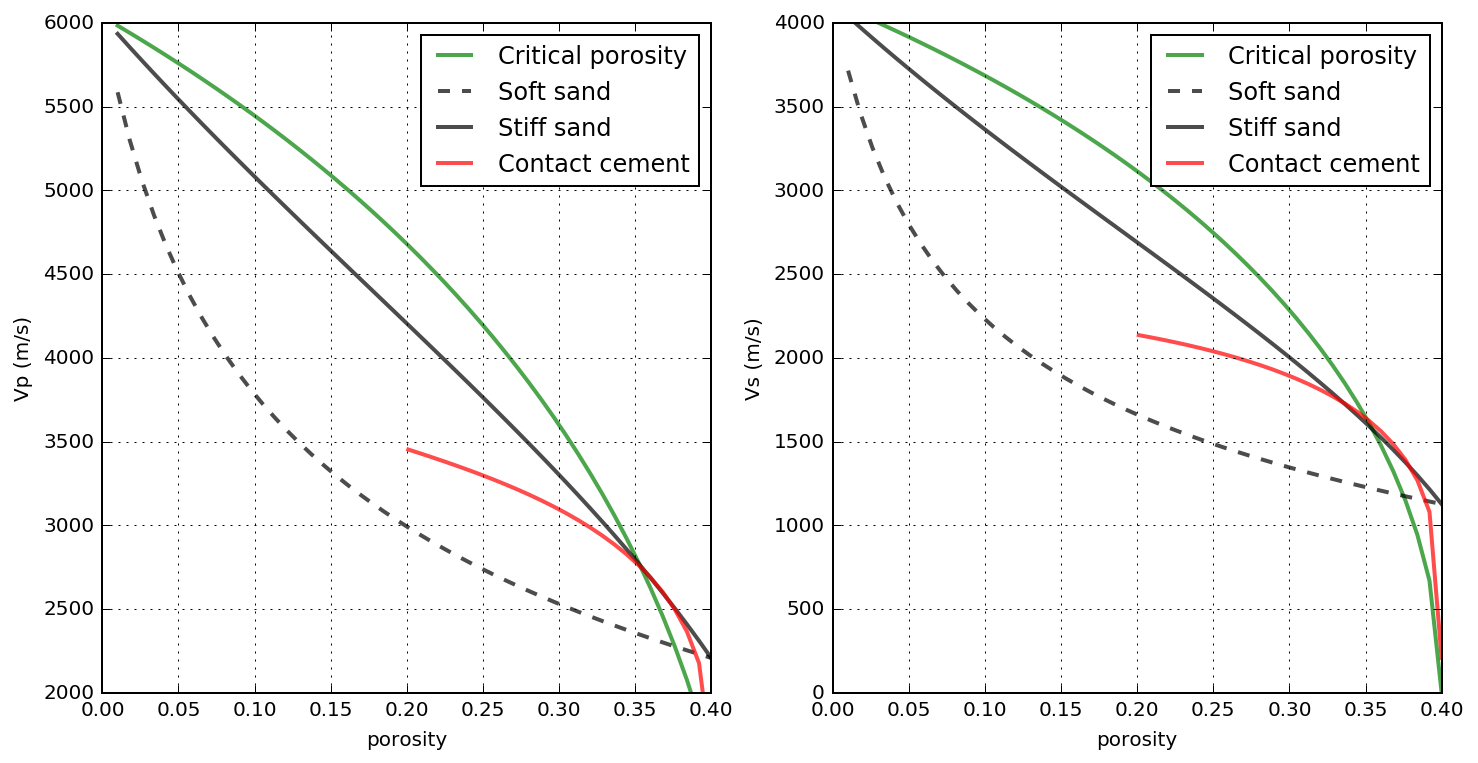

In [6]:
phi=np.linspace(0.01,0.40,50)
vsh=0.0

K0,G0 = vrh([vsh, 1-vsh],[Ksh,Kqz],[Gsh,Gqz])[4:]
D0=vsh*Dsh+(1-vsh)*Dqz

print 'Mineral matrix elastic moduli:'
print 'shale fraction={:.2f}, K={:.2f} GPa, G={:.2f} GPa, rho={:.2f} g/cc'.format(vsh, K0, G0, D0)
Kdry, Gdry = critpor(K0, G0, phi, phic)
vp_cri,vs_cri,_,_= vels(Kdry,Gdry,K0,D0,Kb,Db,phi)

Kdry, Gdry = softsand(K0, G0, phi, phic, Cn, P=30)
vp_ssm,vs_ssm,_,_= vels(Kdry,Gdry,K0,D0,Kb,Db,phi)

Kdry, Gdry = stiffsand(K0, G0, phi, phic, Cn, P=30)
vp_sti,vs_sti,_,_= vels(Kdry,Gdry,K0,D0,Kb,Db,phi)

Kdry, Gdry = contactcement(K0, G0, phi, phic, Cn, Kc, Gc)
vp_ccm,vs_ccm,_,_= vels(Kdry,Gdry,K0,D0,Kb,Db,phi)
vp_ccm[phi<0.2]=np.NaN
vs_ccm[phi<0.2]=np.NaN

f, ax = plt.subplots(1,2, figsize=(12,6))
ax[0].plot(phi,vp_cri,'-g', lw=2, alpha=0.7, label='Critical porosity')
ax[0].plot(phi,vp_ssm,'--k', lw=2, alpha=0.7, label='Soft sand')
ax[0].plot(phi,vp_sti,'-k', lw=2, alpha=0.7, label='Stiff sand')
ax[0].plot(phi,vp_ccm,'-r', lw=2, alpha=0.7, label='Contact cement')
ax[1].plot(phi,vs_cri,'-g', lw=2, alpha=0.7, label='Critical porosity')
ax[1].plot(phi,vs_ssm,'--k', lw=2, alpha=0.7, label='Soft sand')
ax[1].plot(phi,vs_sti,'-k', lw=2, alpha=0.7, label='Stiff sand')
ax[1].plot(phi,vs_ccm,'-r', lw=2, alpha=0.7, label='Contact cement')
ax[0].set_ylim(2000,6000)
ax[0].set_ylabel('Vp (m/s)')
ax[1].set_ylim(0,4000)
ax[1].set_ylabel('Vs (m/s)')
for aa in ax:
    aa.set_xlim(0,0.4)
    aa.grid()
    aa.legend()
    aa.set_xlabel('porosity')

## rock physics templates (RPT)

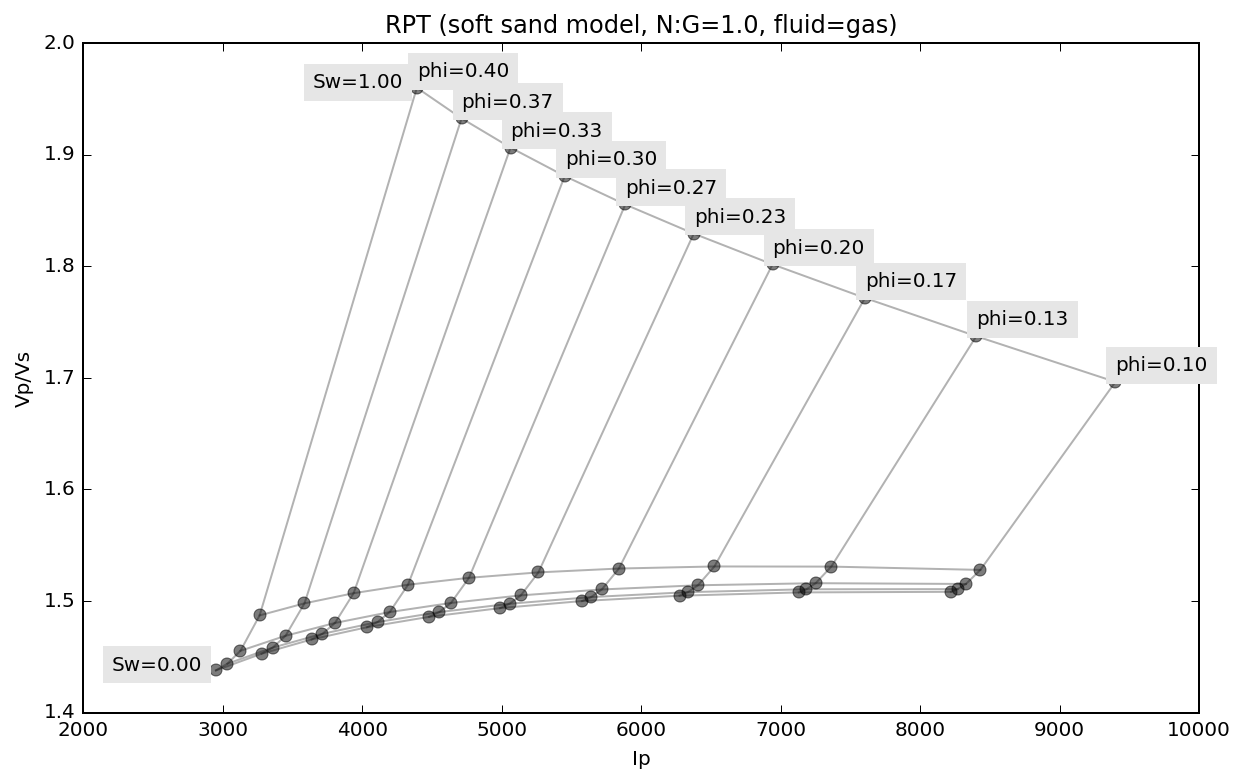

In [7]:
phi=np.linspace(0.10,0.40,10)
sw=np.linspace(0,1,5)
vsh=0.0
fluid='gas'

# elastic moduli of rock matrix
K0,G0 = vrh([vsh, 1-vsh],[Ksh,Kqz],[Gsh,Gqz])[4:]
D0 = vsh*Dsh+(1-vsh)*Dqz

# elastic moduli of dry-rock frame (does not depend on fluid)
Kdry, Gdry = softsand(K0, G0, phi, phic, Cn, P=30)

# setup empty arrays to store Ip and Vp/Vs values
xx=np.empty((phi.size,sw.size))
yy=np.empty((phi.size,sw.size))

# loop over Sw, computes elastic moduli of fluid mixture and saturated rock properties with Gassmann's equation
(Khc, Dhc) = (Kg, Dg) if fluid == 'gas' else (Ko,Do)
for i,val in enumerate(sw):
    Kf = vrh([val,1-val],[Kb,Khc],[999,999])[1] # Reuss average for K is the second output
    Df = val*Db+(1-val)*Dhc
    vp,vs,rho,_= vels(Kdry,Gdry,K0,D0,Kf,Df,phi)
    xx[:,i]=vp*rho
    yy[:,i]=vp/vs
    
plt.figure(figsize=(10,6))
plt.plot(xx, yy, '-ok', alpha=0.3)
plt.plot(xx.T, yy.T, '-ok', alpha=0.3)
for i,val in enumerate(phi):
    plt.text(xx[i,-1],yy[i,-1]+.01,'phi={:.02f}'.format(val), backgroundcolor='0.9')
plt.text(xx[-1,0]-100,yy[-1,0],'Sw={:.02f}'.format(sw[0]),ha='right', backgroundcolor='0.9')
plt.text(xx[-1,-1]-100,yy[-1,-1],'Sw={:.02f}'.format(sw[-1]),ha='right', backgroundcolor='0.9')
plt.xlabel('Ip'), plt.ylabel('Vp/Vs')
plt.title('RPT (soft sand model, N:G={0}, fluid={1})'.format(1-vsh, fluid))

Let's put it all in a function and then make it interactive:

In [8]:
def rpt(model='soft',vsh=0.0,fluid='gas',phic=0.4,Cn=8,P=10,f=1,cement='quartz'):
    if cement=='quartz':
        Kc, Gc = 37, 45
    elif cement=='calcite':
        Kc, Gc = 76.8, 32
    elif cement=='clay':
        Kc, Gc = 21, 7
    phi=np.linspace(0.1,phic-.1,6)
    sw=np.linspace(0,1,5)
    (Khc, Dhc) = (Kg, Dg) if fluid == 'gas' else (Ko,Do)
    K0,G0 = vrh([vsh, 1-vsh],[Ksh,Kqz],[Gsh,Gqz])[4:]
    D0 = vsh*Dsh+(1-vsh)*Dqz
    if model=='soft':
        Kdry, Gdry = softsand(K0,G0,phi,phic,Cn,P,f)
    elif model=='stiff':
         Kdry, Gdry = stiffsand(K0,G0,phi,phic,Cn,P,f)
    elif model=='cem':
         Kdry, Gdry = contactcement(K0,G0,phi,phic,Cn,Kc,Gc,scheme=2)
    elif model=='crit':
         Kdry, Gdry = critpor(K0,G0,phi,phic)
            
    xx=np.empty((phi.size,sw.size))
    yy=np.empty((phi.size,sw.size))

    for i,val in enumerate(sw):
        Kf = vrh([val,1-val],[Kb,Khc],[999,999])[1]
        Df = val*Db+(1-val)*Dhc
        vp,vs,rho,_= vels(Kdry,Gdry,K0,D0,Kf,Df,phi)
        xx[:,i]=vp*rho
        yy[:,i]=vp/vs

    plt.figure(figsize=(10,6))
    plt.plot(xx, yy, '-ok', alpha=0.3)
    plt.plot(xx.T, yy.T, '-ok', alpha=0.3)
    for i,val in enumerate(phi):
        plt.text(xx[i,-1],yy[i,-1]+.01,'$\phi={:.02f}$'.format(val), backgroundcolor='0.9')
    plt.text(xx[-1,0]-100,yy[-1,0],'$S_w={:.02f}$'.format(sw[0]),ha='right', backgroundcolor='0.9')
    plt.text(xx[-1,-1]-100,yy[-1,-1],'$S_w={:.02f}$'.format(sw[-1]),ha='right', backgroundcolor='0.9')
    plt.xlabel('Ip'), plt.ylabel('Vp/Vs')
    plt.xlim(xx.min()-xx.min()*.1,xx.max()+xx.max()*.1)
    plt.ylim(yy.min()-yy.min()*.1,yy.max()+yy.max()*.1)
    plt.title('RPT (N:G={0}, fluid={1})'.format(1-vsh, fluid))

<function __main__.rpt>

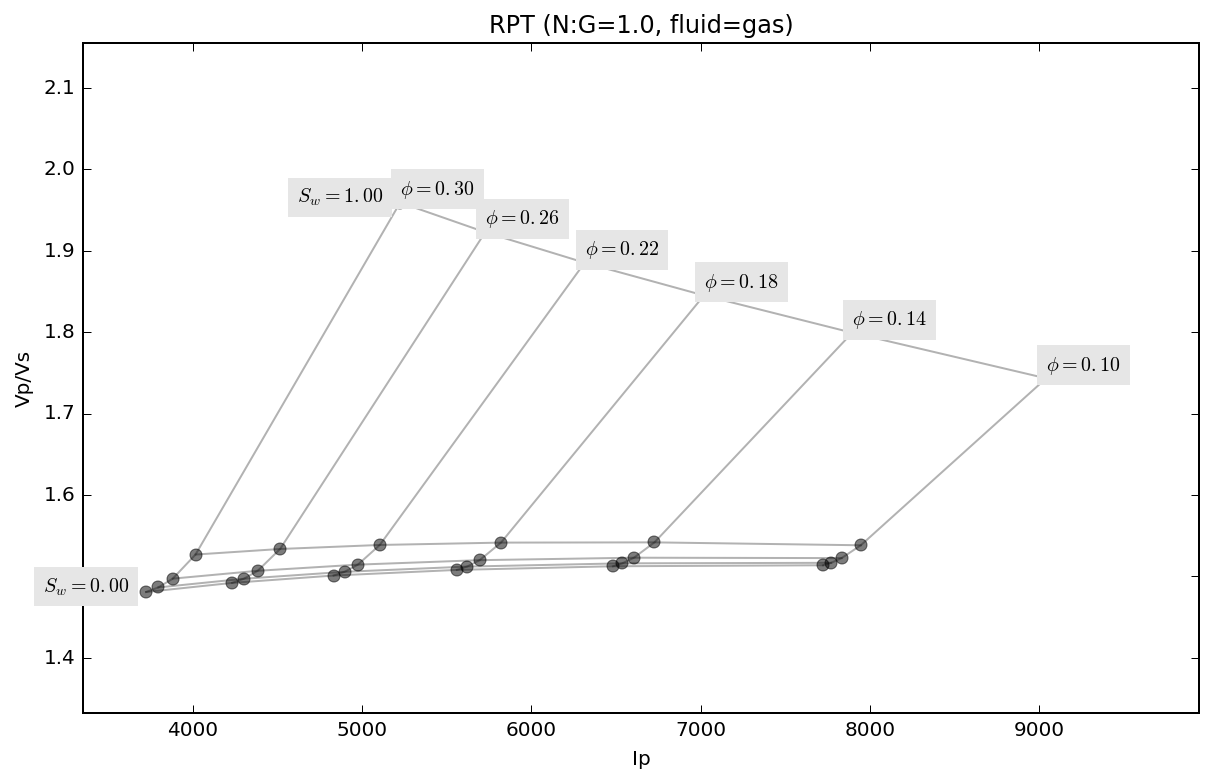

In [9]:
from ipywidgets import interact, ToggleButtons, RadioButtons, HTML
rpm_buttons = ToggleButtons(description='RPM',options=['soft','stiff','cem','crit'])
fluid_buttons = ToggleButtons(description='Fluid',options=['gas','oil'])
cement_buttons = ToggleButtons(description='Cement',options=['quartz','clay','calcite'])
interact(rpt,
         model=rpm_buttons, fluid=fluid_buttons,
         vsh=(0,1,.1),phic=(.2,0.4,.01),Cn=(1,20),P=(1,100),f=(0,1,.1),
         cement=cement_buttons)

## RPT and well log data

Obviously the real power of a template like the one above is to use it to understand real data.

The following is a (static) example using well logs that I have [previously used](http://nbviewer.ipython.org/github/aadm/geophysical_notes/blob/master/seismic_petrophysics.ipynb).

The idea is to use widgets also here so that the user can play with parameters and define the optimal modeling very quickly; unfortunately I had not find a solution to do that, yet.

In [10]:
data=np.genfromtxt('qsiwell2.csv',delimiter=',',names=True)

sel=(data['DEPTH']>=2014) & (data['DEPTH']<=2600)
ww=np.empty((data['DEPTH'][sel].size,3))
ww[:,0]=data['IP'][sel]
ww[:,1]=data['VPVS'][sel]
ww[:,2]=data['VSH'][sel]

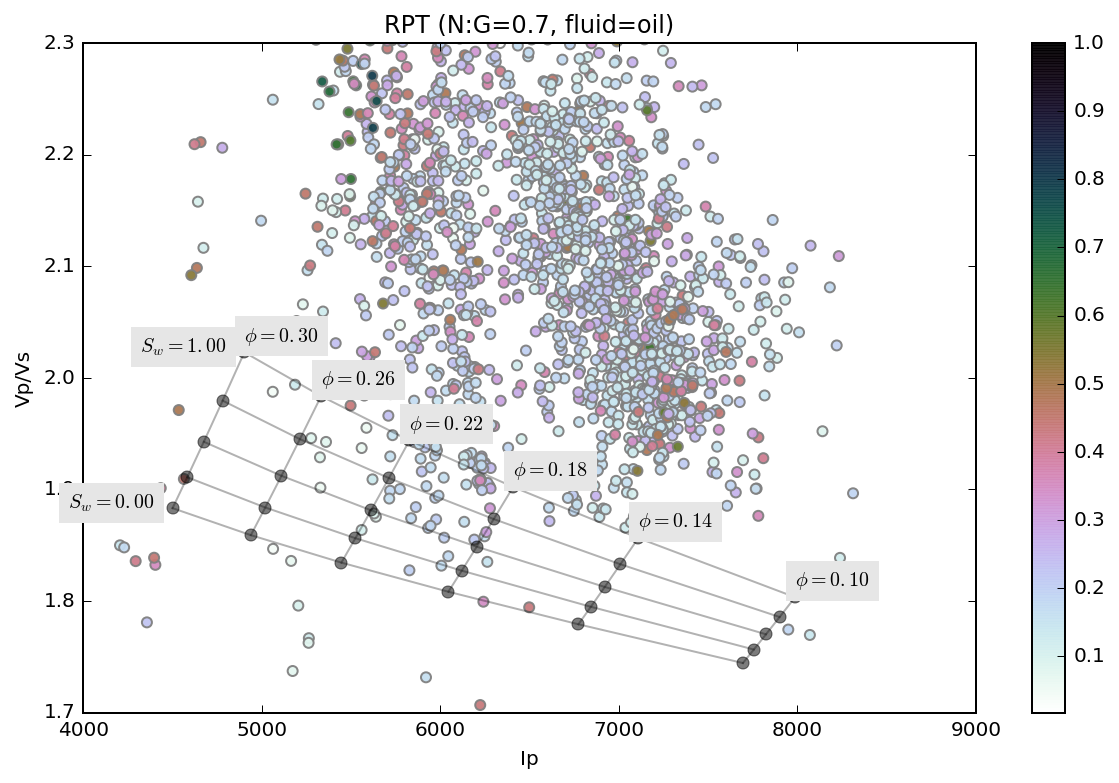

In [11]:
Ksh, Gsh = 12, 4
rpt(model='soft',vsh=0.3,fluid='oil',phic=0.4,Cn=12,P=10)
plt.scatter(ww[:,0],ww[:,1],25,ww[:,2], alpha=0.95, marker='o', edgecolors='.5', cmap='cubehelix_r')
plt.xlim(4000,9000)
plt.ylim(1.7,2.3)
plt.colorbar()

***

<i>Now, this is probably not the best example but I had limited time and only had this log data that I could share publicly; it should be possible to make this data fit with a better combination of model/parameters (after all, this is data used by Avseth et al. in Quantitative Seismic Interpretation -- see also [my other notebooks](https://github.com/aadm/geophysical_notes)).

Also, it is quite possible that I have made mistakes in the code above -- after all, stuff done in my spare time etc., so if you find anything to be corrected [let me know](https://twitter.com/aadmtwi).</i>